🎯 Project Objective
Design and implement a complete object detection system focused on detecting helmets in images. The system should include a graphical user interface (GUI) and must be capable of:

Accepting a static image as input.

Detecting one or more objects (helmets) in the image.

Drawing bounding boxes around each detected object.

Labeling each detected object with its predicted class name.

# 📊 Dataset 
Dataset Name:
Helmet Detection Dataset

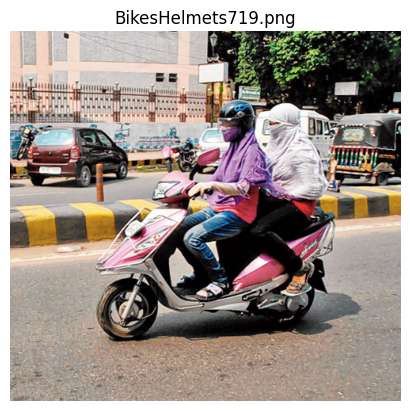

In [1]:
import cv2
import matplotlib.pyplot as plt
import os

# Define dataset path
DATASET_DIR = '/kaggle/input/helmet-detection'
image_dir = os.path.join(DATASET_DIR, 'images')

# List all images in the dataset directory (this will handle multiple images)
image_files = os.listdir(image_dir)
if len(image_files) > 0:
    image_file = image_files[0]  # Choose the first image for display
else:
    print("No images found in the dataset directory.")
    image_file = ''

# Ensure image file is valid and load it
if image_file:
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image:", image_path)
    else:
        # Convert from BGR to RGB for proper display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(image_file)
        plt.axis('off')
        plt.show()


# 🚀 Pipeline Implementation
## 1. Preprocessing and Image Enhancement
The preprocessing steps may include:

Image Resizing

Normalization

Noise Reduction

Contrast Adjustment

Color Space Conversion

Image Augmentation

Thresholding

Blurring and Sharpening Filters

Morphological Operations

In [2]:
import cv2
import numpy as np
import random

def preprocess_image(image, target_size=(256, 256), augment=True):
    """
    Applies preprocessing and enhancement steps to an input image.
    
    Parameters:
        image (numpy array): Input image in RGB format.
        target_size (tuple): Desired size (width, height) for resizing.
        augment (bool): Whether to apply image augmentation.
        
    Returns:
        preprocessed_image (numpy array): Final processed image.
    """
    # 1. Resize
    resized = cv2.resize(image, target_size)

    # 2. Gaussian Blur (Noise Reduction)
    blurred = cv2.GaussianBlur(resized, (5, 5), 0)

    # 3. Contrast Adjustment using CLAHE (on L channel in LAB)
    lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    contrast_adjusted = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # 4. Sharpening Filter
    sharpen_kernel = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(contrast_adjusted, -1, sharpen_kernel)

    # 5. Normalize to [0, 1]
    normalized = sharpened.astype(np.float32) / 255.0

    # 6. Image Augmentation (Random flips, rotation, etc.)
    if augment:
        augmented = augment_image(normalized)
    else:
        augmented = normalized

    # 7. Convert to grayscale (optional for some tasks)
    grayscale = cv2.cvtColor(augmented, cv2.COLOR_RGB2GRAY)

    # 8. Optional: Skip thresholding to avoid black image issues (only if unnecessary for your task)
    # 9. Morphological Operations (Erosion + Dilation) on grayscale or original image
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(augmented, cv2.MORPH_CLOSE, kernel)  # Closing (dilate + erode)

    # Ensure the image stays in a usable color range
    final_image = np.clip(morph, 0, 1)  # Clamp values between 0 and 1

    return final_image



In [3]:
def augment_image(image):
    """
    Applies random augmentations such as flips and rotations to the image.
    
    Parameters:
        image (numpy array): Input image.
        
    Returns:
        augmented_image (numpy array): Augmented image.
    """
    # Random scaling factor between 0.8 and 1.2 (80% to 120%)
    scale_factor = random.uniform(0.8, 1.2)
    
    # Get the new dimensions based on the scaling factor
    new_width = int(image.shape[1] * scale_factor)
    new_height = int(image.shape[0] * scale_factor)
    
    # Resize image using the new dimensions
    scaled_image = cv2.resize(image, (new_width, new_height))
    
    # Optionally, resize it back to the target size (if needed)
    scaled_image = cv2.resize(scaled_image, (image.shape[1], image.shape[0]))


    return  scaled_image



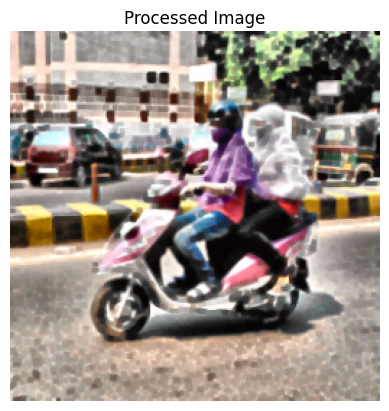

In [4]:
# Load image (from previous step)
image_path = os.path.join(image_dir, 'BikesHelmets719.png')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocess image (including augmentation and all other steps)
processed = preprocess_image(image)

# Show the processed image
import matplotlib.pyplot as plt

plt.imshow(processed)  # Display in RGB format
plt.title("Processed Image")
plt.axis('off')
plt.show()


# 2. Segmentation
Tasks to isolate the regions of interest (ROIs) may involve:

Thresholding

Edge-based methods

Region-based methods

Clustering

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def segment_image_thresholding(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_8bit = (gray * 255).astype(np.uint8)
    _, thresholded = cv2.threshold(gray_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    return morph

def segment_image_canny(image, low_threshold=100, high_threshold=200):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_8bit = np.uint8(gray * 255)
    edges = cv2.Canny(gray_8bit, low_threshold, high_threshold)
    kernel = np.ones((5, 5), np.uint8)
    morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    return morph

def segment_image_sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    return np.uint8(np.absolute(magnitude))

# 5. Region-based (Watershed)
def segment_with_watershed(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = np.uint8(gray * 255)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    markers = cv2.watershed(image_bgr, markers)
    image_bgr[markers == -1] = [255, 0, 0]
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 6. Clustering (K-means)
def segment_with_kmeans(image, K=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape(image.shape)
    return segmented_image
    
# Example usage
image_path = os.path.join(image_dir, 'BikesHelmets719.png')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

processed_image = preprocess_image(image)

# Apply desired method
#segmented = segment_image_thresholding(processed_image)
# segmented = segment_image_canny(processed_image)
# segmented = segment_image_sobel(processed_image)

#plt.imshow(segmented, cmap='gray')
#plt.axis('off')
#plt.title("Segmented Image")
#plt.show()


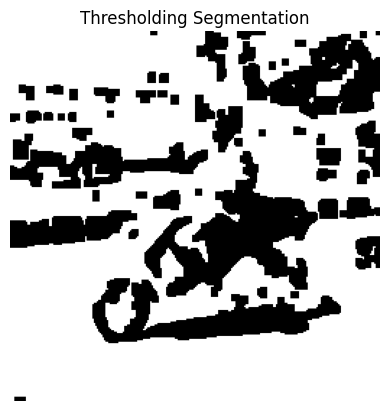

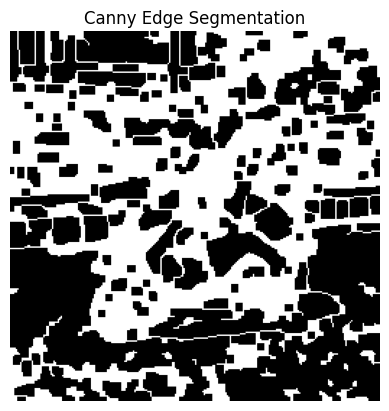

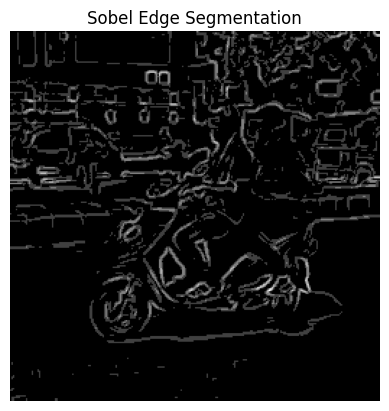

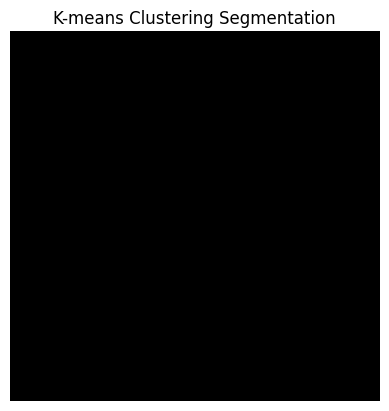

In [7]:
methods = {
    "Thresholding": segment_image_thresholding,
    "Canny Edge": segment_image_canny,
    "Sobel Edge": segment_image_sobel,
    #"Watershed": segment_with_watershed,
    "K-means Clustering": segment_with_kmeans
}
for name, method in methods.items():
    result = method(processed_image)
    plt.figure()
    plt.imshow(result, cmap='gray' if len(result.shape) == 2 else None)
    plt.title(f"{name} Segmentation")
    plt.axis('off')
plt.show()

# 3. Feature Extraction
Extract relevant features from segmented regions for classification.

In [8]:
from skimage.feature import hog
from skimage import exposure
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
# ---------- HOG Feature Extraction ----------
def extract_hog_features(image):
    """
    Extracts Histogram of Oriented Gradients (HOG) features from an image.
    
    Parameters:
        image (numpy array): The input image (can be grayscale or color).
    
    Returns:
        features (numpy array): The HOG feature vector.
        hog_image (numpy array): The image representation of HOG features.
    """
    # Check if the image is already in grayscale
    if len(image.shape) == 3:  # RGB or BGR image
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image  # Already grayscale
    
    # Extract HOG features with more complete parameters
    features, hog_image = hog(gray, 
                            orientations=9,  # Number of orientation bins
                            pixels_per_cell=(8, 8), 
                            cells_per_block=(2, 2),
                            visualize=True)
    return features, hog_image  # Fixed variable name


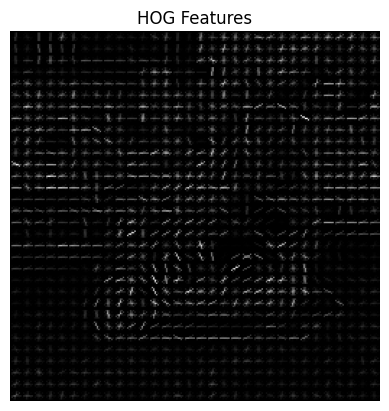

In [9]:
# Example usage
image_path = os.path.join(image_dir, 'BikesHelmets719.png')  # Replace with actual image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Preprocess the image first
processed_image = preprocess_image(image)

# Extract HOG features from the processed image
hog_features, hog_image = extract_hog_features(processed_image)

# Display the HOG image
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.axis('off')
plt.show()


In [10]:
def extract_color_histogram(image):
    """
    Extracts a normalized color histogram from the image.
    
    Parameters:
        image (numpy array): Input image.
        
    Returns:
        color_hist (numpy array): Normalized color histogram.
    """
    # Convert the image to HSV (Hue, Saturation, Value)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Compute histogram for each channel (Hue, Saturation, and Value)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [256], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [256], [0, 256])
    
    # Normalize the histograms
    hist_hue /= hist_hue.sum()
    hist_saturation /= hist_saturation.sum()
    hist_value /= hist_value.sum()
    
    # Combine histograms into one feature vector
    color_hist = np.concatenate((hist_hue.flatten(), hist_saturation.flatten(), hist_value.flatten()))
    
    return color_hist



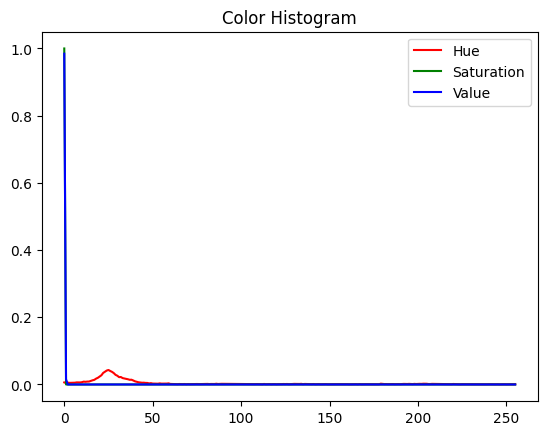

Color Histogram Length: 768


In [11]:
# Example usage
color_histogram = extract_color_histogram(processed_image)

# Display color histogram
plt.plot(color_histogram[:256], color='r', label='Hue')
plt.plot(color_histogram[256:512], color='g', label='Saturation')
plt.plot(color_histogram[512:], color='b', label='Value')
plt.title("Color Histogram")
plt.legend()
plt.show()

# Features for training/ML
print("Color Histogram Length:", len(color_histogram))


In [12]:
def extract_features_from_segmented_image(segmented_image, original_image, min_region_area=100):
    """
    Extracts features from each segmented region, filtering tiny regions.
    """
    gray = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY) if len(segmented_image.shape) == 3 else segmented_image.copy()
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features_list = []
    
    for contour in contours:
        # Skip small regions
        if cv2.contourArea(contour) < min_region_area:
            continue
        
        # Extract ROI
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
        roi = cv2.bitwise_and(original_image, original_image, mask=mask)
        
        # Resize ROI for consistent HOG features
        roi_resized = cv2.resize(roi, (64, 128))  # Standard size for HOG
        
        # Extract features
         # Resize ROI for consistent HOG features
        roi_resized = cv2.resize(roi, (64, 128))  # Standard size for HOG
        # ✅ Skip empty (black) regions
        if np.count_nonzero(roi_resized) == 0:
            continue
            
        hog_features, _ = extract_hog_features(roi_resized)
        color_hist = extract_color_histogram(roi_resized)
        
        # Combine (should be ~2,500 features)
        combined_features = np.concatenate([hog_features, color_hist])
        features_list.append(combined_features)
    
    return features_list

# Example usage
segmented_image = segment_image_canny(processed_image)
features = extract_features_from_segmented_image(segmented_image, processed_image)

print(f"Extracted features from {len(features)} regions:")
for i, feature in enumerate(features):
    print(f"Region {i+1}: {len(feature)} features")

Extracted features from 1 regions:
Region 1: 4548 features


# 4. Classification
Classify detected objects into predefined categories (Helmet or No Helmet).

In [13]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, 
                           confusion_matrix, classification_report)

def parse_annotation(xml_path):
    """Parse XML annotation file and return boxes and labels."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes, labels = [], []
    for obj in root.findall('object'):
        label = obj.find('name').text.lower()  # Convert to lowercase for consistency
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    return boxes, labels

def extract_features_from_annotations(image_dir, annotation_dir):
    """Extract features from all annotated images."""
    features, labels = [], []
    label_mapping = {
        'with_helmet': 1,
        'without_helmet': 0,
        'with helmet': 1,     # Handle spaces
        'without helmet': 0   # Handle spaces
    }
    
    for xml_file in os.listdir(annotation_dir):
        if not xml_file.endswith('.xml'):
            continue
            
        xml_path = os.path.join(annotation_dir, xml_file)
        image_name = xml_file.replace('.xml', '.png')
        image_path = os.path.join(image_dir, image_name)
        
        # Load and validate image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Could not load image {image_path}")
            continue
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes, box_labels = parse_annotation(xml_path)
        
        for box, label in zip(boxes, box_labels):
            xmin, ymin, xmax, ymax = box
            roi = image[ymin:ymax, xmin:xmax]
            
            # Skip empty or too small regions
            if roi.size == 0 or min(roi.shape[:2]) < 10:
                continue
                
            try:
                # Process and extract features
                processed_roi = preprocess_image(roi)
                hog_features, _ = extract_hog_features(processed_roi)
                color_hist = extract_color_histogram(processed_roi)
                
                # Map label to numerical value
                numerical_label = label_mapping.get(label.lower(), 0)  # Default to 0 if unknown
                
                features.append(np.concatenate([hog_features, color_hist]))
                labels.append(numerical_label)
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                continue
    
    if not features:
        raise ValueError("No features were extracted. Check your dataset and annotations.")
    
    return np.array(features), np.array(labels)


# 5. Evaluation and Performance Metrics
Accuracy

Precision

Recall

F1-Score

In [14]:
def evaluate_model(y_true, y_pred):
    """Comprehensive model evaluation."""
    print("\n" + "="*40)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Helmet', 'Helmet']))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    print("\nKey Metrics:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    print("="*40 + "\n")


# Define paths
DATASET_DIR = '/kaggle/input/helmet-detection'
image_dir = os.path.join(DATASET_DIR, 'images')
annotation_dir = os.path.join(DATASET_DIR, 'annotations')

# Extract features
try:
    features, labels = extract_features_from_annotations(image_dir, annotation_dir)
    print(f"Extracted {len(features)} samples with {features.shape[1]} features each")
    print("Class distribution:", np.bincount(labels))


    pca = PCA(n_components=0.85)
    features_reduced = pca.fit_transform(features)
    print(f"Reduced from {features.shape[1]} to {features_reduced.shape[1]} features")

    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(
        features_reduced, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    svm_model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=1.0, gamma='scale',class_weight='balanced')
    )
    svm_model.fit(X_train, y_train)
    
    print(f"Train Accuracy: {svm_model.score(X_train, y_train):.2f}")
    print(f"Test Accuracy: {svm_model.score(X_test, y_test):.2f}")

    print("\nTraining Set Performance:")
    y_train_pred = svm_model.predict(X_train)
    evaluate_model(y_train, y_train_pred)

    print("\nTest Set Performance:")
    y_test_pred = svm_model.predict(X_test)
    evaluate_model(y_test, y_test_pred)
except Exception as e:
    print(f"Pipeline failed: {str(e)}")

Extracted 1429 samples with 35364 features each
Class distribution: [477 952]
Reduced from 35364 to 827 features
Train Accuracy: 1.00
Test Accuracy: 0.67

Training Set Performance:

Classification Report:
              precision    recall  f1-score   support

   No Helmet       0.99      1.00      1.00       382
      Helmet       1.00      1.00      1.00       761

    accuracy                           1.00      1143
   macro avg       1.00      1.00      1.00      1143
weighted avg       1.00      1.00      1.00      1143


Confusion Matrix:
[[382   0]
 [  3 758]]

Key Metrics:
Accuracy:  0.9974
Precision: 1.0000
Recall:    0.9961
F1 Score:  0.9980


Test Set Performance:

Classification Report:
              precision    recall  f1-score   support

   No Helmet       0.50      0.20      0.29        95
      Helmet       0.69      0.90      0.78       191

    accuracy                           0.67       286
   macro avg       0.60      0.55      0.53       286
weighted avg       0

In [21]:
import joblib

# المسار الصحيح للحفظ
joblib.dump(svm_model, "/kaggle/working/svm_model.pkl")
joblib.dump(pca, "/kaggle/working/pca.pkl")


['/kaggle/working/pca.pkl']

In [17]:
# مثال للحفظ في Kaggle بعد التدريب:
import joblib
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(pca, "pca.pkl")


['pca.pkl']

In [20]:
import joblib

svm_model = joblib.load("svm_model.pkl")
pca = joblib.load("pca.pkl")
